<a href="https://colab.research.google.com/github/sunnysavita10/Generative-AI-Indepth-Basic-to-Advance/blob/main/RAG_with_Conversation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma beautifulsoup4
!pip install -q langchain_google_genai

gootle_api_key = https://aistudio.google.com/app/apikey

langsmith_api_key = https://smith.langchain.com/o/2b36e0a1-975c-5806-b1e4-d6ee61291578/?paginationState=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A5%7D

tavily_api_key = https://app.tavily.com/home?code=agSQxU1mafqqUJbBeeDMnjIM1b4DsEtCPrzDP5gNFhSEx&state=eyJyZXR1cm5UbyI6Ii9ob21lIn0

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "RAG_With_Memory"

In [3]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

model = https://ai.google.dev/gemini-api/docs/models/gemini

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.0-pro",convert_system_message_to_human=True)

In [11]:
print(model.invoke("hi").content)

Hello! How are you doing today?


In [12]:
import bs4
from langchain import hub

In [13]:
from langchain.chains import create_retrieval_chain # Builds chain to retrieve relevant documents(using a retriever) and process the retrieved documents with (LLM)

In [14]:
from langchain.chains.combine_documents import create_stuff_documents_chain # Create chain to combines set of already-retrieved documents into unified output using llm

In [15]:
from langchain_chroma import Chroma # vector database

In [16]:
from langchain_community.document_loaders import WebBaseLoader # fetch the data directly from the internet

In [17]:
from langchain_core.prompts import ChatPromptTemplate

In [18]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [19]:
from langchain_core.prompts import MessagesPlaceholder

In [20]:
loader = WebBaseLoader( # scrape and load web content for further processing
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=("post-content", "post-title", "post-header")) # Specifies the HTML classes to extract content (web scrapping using beautiful soup)
    ),
)


In [21]:
doc = loader.load()

In [22]:
doc

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [23]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(doc)

In [24]:
vectorstore = Chroma.from_documents(documents=splits, embedding=gemini_embeddings)
retriever = vectorstore.as_retriever()

In [25]:
retriever

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7a63a2196350>)

In [26]:
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question "
    "If you don't know the answer, say that you don't know."
    "Use three sentences maximum and keep the answer concise."
    "\n\n"
    "{context}"
)

In [27]:
chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [28]:
# Create chain to combines set of already-retrieved documents into unified output using llm
question_answering_chain=create_stuff_documents_chain(model, chat_prompt)

In [29]:
# Builds chain to retrieve relevant documents(using a retriever) and process the retrieved documents with (LLM)
rag_chain = create_retrieval_chain(retriever, question_answering_chain)

In [30]:
response = rag_chain.invoke({"input":"what is MRKL?"})

In [31]:
response["answer"]

'MRKL stands for Modular Reasoning, Knowledge and Language. It is a neuro-symbolic architecture for autonomous agents that contains a collection of "expert" modules and a general-purpose LLM that routes inquiries to the best suitable expert module.'

In [32]:
from langchain.chains import create_history_aware_retriever


In [33]:
retriever_prompt = (
    "Given a chat history and the latest user question which might reference context in the chat history,"
    "formulate a standalone question which can be understood without the chat history."
    "Do NOT answer the question, just reformulate it if needed and otherwise return it as is."
)

In [34]:
contextualize_q_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", retriever_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),


     ]
)

In [35]:
history_aware_retriever = create_history_aware_retriever(model,retriever,contextualize_q_prompt)

### Architecture 
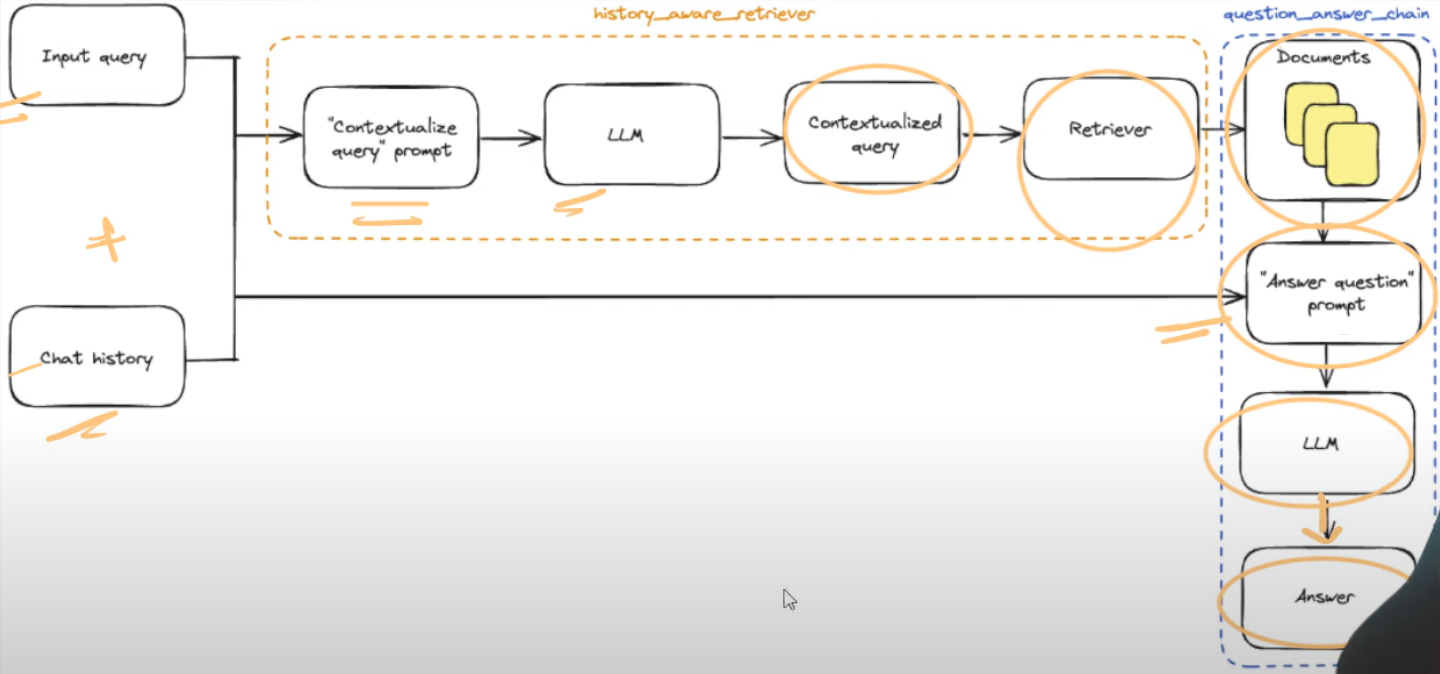

In [36]:
from langchain.chains import create_retrieval_chain

In [37]:
from langchain.chains.combine_documents import create_stuff_documents_chain

In [38]:
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

In [39]:
question_answer_chain = create_stuff_documents_chain(model, qa_prompt)

In [40]:
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [41]:
from langchain_core.messages import HumanMessage, AIMessage

In [42]:
chat_history = []

In [43]:
question1 = "what is Task Decomposition?"

In [44]:
message1= rag_chain.invoke({"input": question1, "chat_history": chat_history})

In [45]:
message1["answer"]

'Task decomposition is a technique that breaks down complex tasks into smaller, more manageable steps. This can be done using various methods, such as LLM prompting, task-specific instructions, or human input. Task decomposition helps agents plan ahead and execute tasks more efficiently.'

In [46]:
chat_history.extend(
    [
        HumanMessage(content=question1),  # Appends the user's question
        AIMessage(content=message1["answer"]),  # Appends the AI's response
    ]
)

### Difference Between .extend() and .append()
.extend(): Adds each element of an iterable (e.g., list, tuple) to the list individually.

Example:
lst = [1, 2]

lst.extend([3, 4])  # Adds 3 and 4 separately

print(lst)  # [1, 2, 3, 4]

.append(): Adds the entire object (e.g., list, string) as a single element.

Example:

lst = [1, 2]

lst.append([3, 4])  # Adds [3, 4] as one element

print(lst)  # [1, 2, [3, 4]]

Key Difference: .extend() unpacks and adds, .append() adds as-is.

In [47]:
chat_history


[HumanMessage(content='what is Task Decomposition?'),
 AIMessage(content='Task decomposition is a technique that breaks down complex tasks into smaller, more manageable steps. This can be done using various methods, such as LLM prompting, task-specific instructions, or human input. Task decomposition helps agents plan ahead and execute tasks more efficiently.')]

In [48]:
second_question = "What are common ways of doing it?"
message2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(message2["answer"])

Common ways of doing task decomposition include:

1. **LLM prompting:** Instructing the LLM to "think step by step" or "decompose the task into smaller steps."
2. **Task-specific instructions:** Providing the LLM with specific instructions on how to break down the task, such as "Write a story outline" for writing a novel.
3. **Human input:** Manually decomposing the task into smaller steps and providing the LLM with the decomposed task.


ChatHistory Message = https://github.com/langchain-ai/langchain/blob/master/libs/core/langchain_core/chat_history.py

### 1. BaseChatMessageHistory
What it is: An abstract class or blueprint.

Purpose: Defines the structure and methods that every chat history management system must follow.

Key Features:
It is not functional on its own.
Provides a common interface for implementing custom chat history storage (e.g., in-memory, database, or cloud-based storage).

Example Use Case: If you need to store chat history in a database (e.g., MongoDB), you would extend BaseChatMessageHistory to implement the logic for saving and retrieving messages.

### 4. ChatMessageHistory
What it is: A partially implemented version of BaseChatMessageHistory.

Purpose: Provides a foundation for creating custom chat history storage backends.

Key Features:
Adds pre-defined methods for managing chat messages.
Requires customization to define specific storage logic (e.g., file, database).

Example Use Case: Use this to create a custom storage system like saving chat history to a database

### 2. InMemoryChatMessageHistory
What it is: A concrete implementation of BaseChatMessageHistory.

Purpose: Provides an in-memory storage solution for chat histories.

Key Features:
Stores messages in RAM.
Easy to use for prototyping or lightweight systems.
Loses the data when the application shuts down.

Example Use Case: Use this if you are building a small chatbot prototype where persistent storage isn't required.

### 3. RunnableWithMessageHistory
What it is: A specialized tool that combines:
A runnable: A reusable computational component (e.g., a task like calling an AI model or an API).
Message history management: Access to and integration of chat history.

Purpose: Enables workflows or tasks to make decisions or computations while using message history as context.

Key Features:
Makes message history available during the execution of tasks.
Useful for chaining tasks that depend on previous messages in a conversation.

Example Use Case: If you want to build a chatbot where:
The AI uses the full history of the conversation to provide relevant responses.
The chatbot performs computations or calls external tools based on the conversation context.

#### Store conversation as history

In [49]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [50]:
store = {}

In [52]:
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [53]:
conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history, # retrieving the chat history
    input_messages_key="input", # key where the user's question is stored
    history_messages_key="chat_history", # key where the chat history is stored
    output_messages_key="answer", # key where the generated answer is stored
)

In [54]:
conversational_rag_chain.invoke(
    {"input": "What is Task Decomposition?"},
    config={ # configurable is used to specify unique parameters for the conversation
        "configurable": {"session_id": "abc123"} # config tells the system that this message belongs to the conversation session with ID "abc123"
    },  # constructs a key "abc123" in `store`.
)["answer"]

'Task decomposition involves breaking down a complex task into smaller, manageable steps. It can be done through LLM prompting techniques, task-specific instructions, or human inputs. The purpose of task decomposition is to make complex tasks more manageable for AI agents.'

In [55]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What is Task Decomposition?'), AIMessage(content='Task decomposition involves breaking down a complex task into smaller, manageable steps. It can be done through LLM prompting techniques, task-specific instructions, or human inputs. The purpose of task decomposition is to make complex tasks more manageable for AI agents.')])}

In [56]:
conversational_rag_chain.invoke(
    {"input": "What are common ways of doing it?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'Common ways of doing task decomposition include using LLM prompting techniques like Chain of Thought (CoT) or Tree of Thoughts (ToT), providing task-specific instructions, or obtaining human inputs to break down the task into smaller steps.'

In [57]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition involves breaking down a complex task into smaller, manageable steps. It can be done through LLM prompting techniques, task-specific instructions, or human inputs. The purpose of task decomposition is to make complex tasks more manageable for AI agents.

User: What are common ways of doing it?

AI: Common ways of doing task decomposition include using LLM prompting techniques like Chain of Thought (CoT) or Tree of Thoughts (ToT), providing task-specific instructions, or obtaining human inputs to break down the task into smaller steps.



In [58]:
conversational_rag_chain.invoke(
    {"input": "What is a prompt technique like step xyz?"},
    config={"configurable": {"session_id": "abc123"}},
)["answer"]

'A prompt technique like "Step XYZ" is a type of instruction given to a language model (LM) or other AI system to guide it in performing a task. It typically involves breaking down a complex task into a series of smaller, more manageable steps. The LM is then prompted to execute each step in sequence, with the output of one step becoming the input for the next. This technique can help the LM to reason through complex problems and generate more accurate and coherent responses.'

In [ ]:
store

In [59]:
for message in store["abc123"].messages:
    if isinstance(message, AIMessage):
        prefix = "AI"
    else:
        prefix = "User"

    print(f"{prefix}: {message.content}\n")

User: What is Task Decomposition?

AI: Task decomposition involves breaking down a complex task into smaller, manageable steps. It can be done through LLM prompting techniques, task-specific instructions, or human inputs. The purpose of task decomposition is to make complex tasks more manageable for AI agents.

User: What are common ways of doing it?

AI: Common ways of doing task decomposition include using LLM prompting techniques like Chain of Thought (CoT) or Tree of Thoughts (ToT), providing task-specific instructions, or obtaining human inputs to break down the task into smaller steps.

User: What is a prompt technique like step xyz?

AI: A prompt technique like "Step XYZ" is a type of instruction given to a language model (LM) or other AI system to guide it in performing a task. It typically involves breaking down a complex task into a series of smaller, more manageable steps. The LM is then prompted to execute each step in sequence, with the output of one step becoming the inpu